In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

import os 
print(os.getcwd())

C:\Users\hiwuq


### data set general review

In [17]:
df=pd.read_csv("energydata_complete.csv", parse_dates=["date"], index_col=[0])
df.head(15)
df.tail(10)
df.shape


test_perc=round(len(df)*0.2)
df_train=df[0:-test_perc]
df_test=df[-test_perc:]
print(df_train.shape, df_test.shape)

df_train.describe()

19735 28
(15788, 28) (3947, 28)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,...,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000
mean,98.024449,4.314036,21.152184,40.037455,19.631593,40.556150,21.588743,39.339250,20.148708,38.917235,...,18.768534,41.406689,5.855215,755.401923,81.834642,4.276856,38.672314,2.731101,25.025954,25.025954
std,105.198291,8.363499,1.214241,3.593212,1.516601,3.396775,1.498186,3.205111,1.508309,4.276400,...,1.425592,4.065698,4.129179,7.778350,12.920004,2.555565,12.402705,3.523068,14.521067,14.521067
min,10.000000,0.000000,16.790000,27.733333,16.100000,25.763333,17.200000,32.626667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,31.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.500000,37.290000,18.566667,38.266667,20.500000,36.966667,19.200000,35.462500,...,17.790000,38.497500,2.950000,750.600000,73.333333,2.000000,29.000000,0.400000,12.585736,12.585736
50%,60.000000,0.000000,21.290000,39.530000,19.566667,40.560000,21.633333,38.633333,20.260000,38.290000,...,18.700000,40.663333,5.800000,755.933333,85.333333,4.000000,40.000000,2.757143,24.917394,24.917394
75%,100.000000,10.000000,22.000000,42.722708,20.600000,43.126667,22.600000,41.790000,21.200000,41.863333,...,20.000000,44.000000,8.800000,761.366667,92.000000,6.000000,40.000000,5.200000,37.733747,37.733747
max,1080.000000,70.000000,24.100000,63.360000,24.600000,56.026667,27.600000,50.163333,23.760000,51.090000,...,23.840000,53.326667,19.700000,772.300000,100.000000,14.000000,66.000000,11.400000,49.996530,49.996530


### Data Preprocessing 

In [52]:
scaler=MinMaxScaler(feature_range=(0,1))
df_train_scaled=scaler.fit_transform(df_train)
df_test_scaled=scaler.fit_transform(df_test)

print(df_train_scaled[0:3])
print(len(df_train_scaled),len(df_train_scaled[0]))

def createDP(dataset, window):  # function to create sequential training data point, 
    dataX, dataY=[],[]
    for i in range(window,len(dataset)):
        dataX.append(dataset[i-window:i,1:dataset.shape[1]])
        dataY.append(dataset[i,0])
    return np.array(dataX), np.array(dataY)

trainX,trainY=createDP(df_train_scaled, 72)  # 10 min per record, 72 records cover 12 hour pattern
testX,testY=createDP(df_test_scaled, 72)  

print(len(trainX),len(trainX[0]),len(trainX[0][0]), trainY.shape)
print(trainX[0][1], "\n", trainX[1][0])  # DP0 item 1 is also DP1 item 0 

[[0.04672897 0.42857143 0.42407661 0.55754117 0.36470588 0.6287036
  0.24903846 0.69017297 0.45034642 0.76426234 0.24047134 0.32541353
  0.47858405 0.84182676 0.2213616  0.6534279  0.21289355 0.66141193
  0.23947858 0.67729029 0.46963563 0.09767442 0.88405797 0.5
  0.95384615 0.66111111 0.26544891 0.26544891]
 [0.04672897 0.42857143 0.42407661 0.53218563 0.36470588 0.62647318
  0.24903846 0.69359437 0.45034642 0.78243705 0.24047134 0.32541353
  0.47151648 0.83987192 0.2213616  0.65106383 0.21289355 0.66015536
  0.24320298 0.67853201 0.46491228 0.1        0.88405797 0.47619048
  0.89487179 0.65555556 0.37208289 0.37208289]
 [0.03738318 0.42857143 0.42407661 0.52114521 0.36470588 0.62330653
  0.24903846 0.70176772 0.44187837 0.77806231 0.24047134 0.32360902
  0.4615244  0.83070442 0.2213616  0.6465721  0.21289355 0.65558602
  0.23575419 0.67604857 0.46018893 0.10232558 0.88405797 0.45238095
  0.83589744 0.65       0.57284766 0.57284766]]
15788 28
15716 72 27 (15716,)
[0.42857143 0.424076

### Model building and Hyperparameter tuning 

In [53]:
def build_model(optimizer):
    grid_model=Sequential()
    grid_model.add(LSTM(100, return_sequences=True, input_shape=(72,27)))
    grid_model.add(LSTM(100))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    
    grid_model.compile(loss='mse', optimizer=optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(trainX,trainY)
    
    
    


Epoch 1/8
492/492 [==============================] - 27s 48ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 2/8
492/492 [==============================] - 23s 48ms/step - loss: 0.0081 - val_loss: 0.0143
Epoch 3/8
492/492 [==============================] - 24s 48ms/step - loss: 0.0080 - val_loss: 0.0108
Epoch 4/8
492/492 [==============================] - 24s 48ms/step - loss: 0.0077 - val_loss: 0.0110
Epoch 5/8
492/492 [==============================] - 24s 48ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 6/8
492/492 [==============================] - 24s 49ms/step - loss: 0.0074 - val_loss: 0.0110
Epoch 7/8
492/492 [==============================] - 24s 49ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 8/8
492/492 [==============================] - 6s 12ms/step - loss: 0.0121
Epoch 1/8
492/492 [==============================] - 28s 50ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 2/8
492/492 [==============================] - 24s 49ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 3/8


393/393 [==============================] - 20s 51ms/step - loss: 0.0075 - val_loss: 0.0120
Epoch 5/8
393/393 [==============================] - 20s 51ms/step - loss: 0.0075 - val_loss: 0.0121
Epoch 6/8
393/393 [==============================] - 20s 51ms/step - loss: 0.0072 - val_loss: 0.0119
Epoch 7/8
393/393 [==============================] - 20s 51ms/step - loss: 0.0072 - val_loss: 0.0122
Epoch 8/8
393/393 [==============================] - 5s 12ms/step - loss: 0.0098
Epoch 1/8
393/393 [==============================] - 24s 52ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 2/8
393/393 [==============================] - 20s 51ms/step - loss: 0.0093 - val_loss: 0.0128
Epoch 3/8
393/393 [==============================] - 20s 51ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 4/8
393/393 [==============================] - 20s 51ms/step - loss: 0.0088 - val_loss: 0.0112
Epoch 5/8
393/393 [==============================] - 22s 56ms/step - loss: 0.0084 - val_loss: 0.0111
Epoch 6/8
393/393 [=

983/983 [==============================] - 45s 46ms/step - loss: 0.0074 - val_loss: 0.0110
Epoch 8/10
983/983 [==============================] - 45s 46ms/step - loss: 0.0073 - val_loss: 0.0108
Epoch 9/10
983/983 [==============================] - 45s 46ms/step - loss: 0.0072 - val_loss: 0.0110
Epoch 10/10
983/983 [==============================] - 45s 46ms/step - loss: 0.0070 - val_loss: 0.0111


### This is the best hyperparameter

In [54]:
print("Best parameters are:", "\n", grid_search.best_params_)

select_model=grid_search.best_estimator_.model


Best parameters are: 
 {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}


### Performance assessment

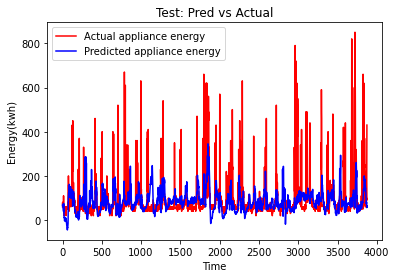

In [67]:
test_pred_scaled=select_model.predict(testX)

test_pred_scaled_shapeholder=np.repeat(test_pred_scaled,28,axis=-1)
test_pred=scaler.inverse_transform(np.reshape(test_pred_scaled_shapeholder, (len(test_pred_scaled),28)))[:,0]

test_actual_scaled_shapeholder=np.repeat(testY,28,axis=-1)
test_actual=scaler.inverse_transform(np.reshape(test_actual_scaled_shapeholder, (len(testY), 28)))[:,0]

plt.plot(test_actual, color='red', label='Actual appliance energy')
plt.plot(test_pred, color='blue',label='Predicted appliance energy')
plt.title('Test: Pred vs Actual')
plt.xlabel('Time')
plt.ylabel('Energy(kwh)')
plt.legend()
plt.show()



In [68]:
## Save model results

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
select_model.save('Model_future_value.h5')
print('Model Saved!')

import pickle
scalerfile = 'scaler_model_future_value.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))

Model Saved!
